# Introduction

# Libraries

In [8]:
# Loading in data:
import numpy as np
import pandas as pd
#import feather

# Plotting:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Maps:
import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import geopandas as gpd
import shapely.geometry as geom
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import folium

# Parsing:
import requests
import requests_cache
import lxml
from bs4 import BeautifulSoup
import bs4
import re

# Reading in the Data

See the other notebook for the process of reading, scraping, and cleaning the data.  

In [14]:
# Read the data from the h5 file exported in the other notebook
street2 = pd.HDFStore('street.h5')
street = street2.select('/table')
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  322566 2008-11-30 22:56:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
1  322560 2008-11-30 22:24:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
2  322559 2008-11-30 22:20:00 2008-12-01 06:07:00  Closed      DPW Ops Queue   
3  322556 2008-11-30 21:34:00 2008-12-09 08:07:00  Closed      DPW Ops Queue   
4  322545 2008-11-30 20:45:00 2009-02-03 07:09:00  Closed      DPW Ops Queue   

                                        Address                      Category  \
0        1566 HYDE ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
1         Intersection of TAYLOR ST and TURK ST  Street and Sidewalk Cleaning   
2  1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
3          Intersection of 25TH ST and LUCKY ST  Street and Sidewalk Cleaning   
4        Intersection of 19TH ST and OAKWOOD ST  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source  Supervisor District  \
0  Sidewalk_Cleaning               Garbage  Voice In                  3.0   
1    Illegal_Dumping               Garbage  Voice In                  6.0   
2    Illegal_Dumping              Mattress  Voice In                  3.0   
3  Sidewalk_Cleaning  Human_waste_or_urine  Voice In                  9.0   
4  Sidewalk_Cleaning            Empty_cart  Voice In                  8.0   

            Neighborhood             Updated  \
0               Nob Hill 2009-07-21 16:24:00   
1  Downtown/Civic Center 2009-07-21 16:24:00   
2               Nob Hill 2008-12-01 06:07:00   
3                Mission 2008-12-09 08:07:00   
4                Mission 2009-02-03 07:09:00   

                                   Point  
0         (37.795328529, -122.418067787)  
1  (37.7832142923006, -122.410764953722)  
2   (37.791643509125, -122.419260423291)  
3  (37.7509362479361, -122.413364630104)  
4   (37.7598935230725, -122.42486308879)

Some basic statistics on the dataset we are starting with:

In [15]:
numRows = street.shape[0]
print "We are working with", numRows, "rows."
print "Our dates range from", street.loc[numRows - 1, "Opened"],"to", street.loc[0, "Opened"], "."

We are working with 747388 rows.
Our dates range from 2017-01-22 00:26:01 to 2008-11-30 22:56:00 .


We supplemented this data with demographic statistics from [city-data.com](http://www.city-data.com/nbmaps/neigh-San-Francisco-California.html).  

In [16]:
demographic = pd.DataFrame.from_csv("demographic.csv")
demographic.head()

AreaSqMi  Females  HousePrice   Males  MedAgeF  MedAgeM  \
0      0.144   2461.0   1988926.0  3916.0     38.6     35.4   
1      0.124    944.0    455053.0  1177.0     38.9     41.2   
3      0.055    774.0         NaN  1365.0     35.2     35.1   
12     0.138   1009.0   1423695.0  1492.0     39.4     41.7   
13     0.526   5261.0   1843918.0  7671.0     38.4     41.7   

    MedHouseholdIncome  MedRent  Neighborhood  PeoplePerSqMi  Population  
0              93901.0   1754.0  Alamo Square        44418.0      6379.0  
1             104697.0   1937.0    Anza Vista        17080.0      2122.0  
3             134523.0   2489.0      Baja Noe        38816.0      2141.0  
12            144714.0   1813.0   Buena Vista        18167.0      2502.0  
13            142771.0   1946.0        Castro        24605.0     12935.0

In [17]:
street = street.merge(demographic, on = "Neighborhood", how = "left") 
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  322566 2008-11-30 22:56:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
1  322560 2008-11-30 22:24:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
2  322559 2008-11-30 22:20:00 2008-12-01 06:07:00  Closed      DPW Ops Queue   
3  322556 2008-11-30 21:34:00 2008-12-09 08:07:00  Closed      DPW Ops Queue   
4  322545 2008-11-30 20:45:00 2009-02-03 07:09:00  Closed      DPW Ops Queue   

                                        Address                      Category  \
0        1566 HYDE ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
1         Intersection of TAYLOR ST and TURK ST  Street and Sidewalk Cleaning   
2  1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
3          Intersection of 25TH ST and LUCKY ST  Street and Sidewalk Cleaning   
4        Intersection of 19TH ST and OAKWOOD ST  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source     ...      AreaSqMi  \
0  Sidewalk_Cleaning               Garbage  Voice In     ...         0.313   
1    Illegal_Dumping               Garbage  Voice In     ...           NaN   
2    Illegal_Dumping              Mattress  Voice In     ...         0.313   
3  Sidewalk_Cleaning  Human_waste_or_urine  Voice In     ...         1.481   
4  Sidewalk_Cleaning            Empty_cart  Voice In     ...         1.481   

   Females HousePrice    Males  MedAgeF  MedAgeM  MedHouseholdIncome  MedRent  \
0  10219.0  1276501.0   9415.0     41.4     39.1             88845.0   1401.0   
1      NaN        NaN      NaN      NaN      NaN                 NaN      NaN   
2  10219.0  1276501.0   9415.0     41.4     39.1             88845.0   1401.0   
3  20187.0   799159.0  25373.0     36.9     36.2             96288.0   1461.0   
4  20187.0   799159.0  25373.0     36.9     36.2             96288.0   1461.0   

   PeoplePerSqMi  Population  
0        62679.0     19633.0  
1            NaN         NaN  
2        62679.0     19633.0  
3        30764.0     45565.0  
4        30764.0     45565.0  

[5 rows x 24 columns]

# Plots

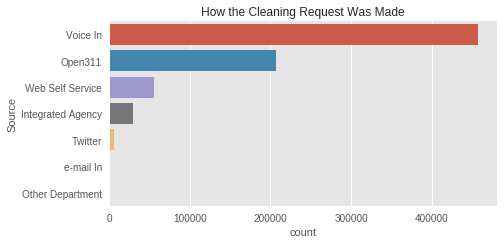

In [18]:
#plt.figure(figsize=(2,100)) # Doesn't do much
theOrder = ["Voice In", "Open311", "Web Self Service", "Integrated Agency", "Twitter", "e-mail In", "Other Department"]
#sns.set(font_scale = 1.5)
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Source", data = street, kind = "count", orient = "h", order = theOrder, aspect = 2)#, size = 10)
plt.title("How the Cleaning Request Was Made") 
plt.show()

According to [the project's website](http://www.open311.org/learn/), Open311 allows people to report issues in public spaces to city officials through a [website](https://sf311.org/index.aspx?page=797) or [mobile app](https://www.sf311.org/mobile).  

In [19]:
street.Neighborhood.value_counts

<bound method Series.value_counts of 0                      Nob Hill
1         Downtown/Civic Center
2                      Nob Hill
3                       Mission
4                       Mission
5                       Mission
6                       Mission
7                       Mission
8            West of Twin Peaks
9            West of Twin Peaks
10                      Mission
11              South of Market
12             Western Addition
13                Outer Mission
14               Bernal Heights
15                     Nob Hill
16              South of Market
17                      Mission
18                 Russian Hill
19                     Nob Hill
20        Downtown/Civic Center
21             Western Addition
22             Western Addition
23                 Outer Sunset
24                     Nob Hill
25               Outer Richmond
26              South of Market
27              South of Market
28          Castro/Upper Market
29          Castro/Upper Market
   

In [20]:
# From: http://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
counts = street.groupby('Neighborhood').count()

We can get the total number of cases from CaseID
unresolved cases by neighborhood

In [21]:
counts = counts.sort_values(by = "CaseID",
                            ascending = False)
counts = counts.reset_index()
counts['UnclosedProp'] = (counts.Opened - counts.Closed) / counts.Opened
counts.head()

Neighborhood  CaseID  Opened  Closed  Status  Responsible Agency  \
0                Mission  103254  103254  101783  103254              103254   
1        South of Market   70221   70221   69009   70221               70221   
2             Tenderloin   29747   29747   29272   29747               29747   
3                Bayview   28256   28256   27916   28256               28256   
4  Downtown/Civic Center   27985   27985   27948   27985               27985   

   Address  Category  Request Type  Request Details      ...       Females  \
0   103254    103254        103242           103240      ...        103254   
1    70221     70221         70215            70215      ...         70221   
2    29747     29747         29746            29746      ...         29747   
3    28256     28256         28256            28255      ...         28256   
4    27985     27985         27985            27984      ...             0   

   HousePrice   Males  MedAgeF  MedAgeM  MedHouseholdIncome  MedRent  \
0      103254  103254   103254   103254              103254   103254   
1           0   70221    70221    70221               70221    70221   
2           0   29747    29747    29747               29747    29747   
3       28256   28256    28256    28256               28256    28256   
4           0       0        0        0                   0        0   

   PeoplePerSqMi  Population  UnclosedProp  
0         103254      103254      0.014246  
1          70221       70221      0.017260  
2          29747       29747      0.015968  
3          28256       28256      0.012033  
4              0           0      0.001322  

[5 rows x 25 columns]

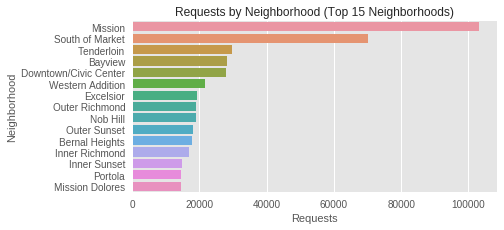

In [22]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

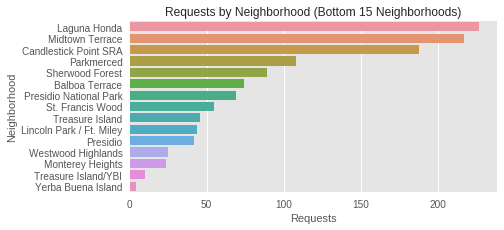

In [23]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.tail(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Bottom 15 Neighborhoods)") 
plt.show()

To get a sense of where these neighborhood fall on a map, we created this plot:

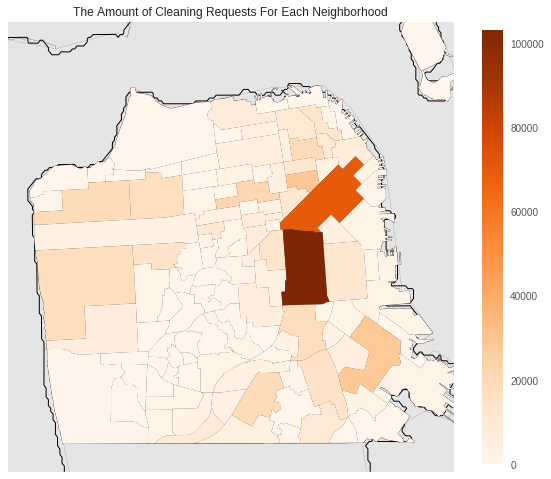

In [24]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, llcrnrlat=37.7, urcrnrlon=-122.36, urcrnrlat=37.83, resolution="f",
    projection="merc") 
myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", 
                    "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['Opened'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['Opened'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Amount of Cleaning Requests For Each Neighborhood")

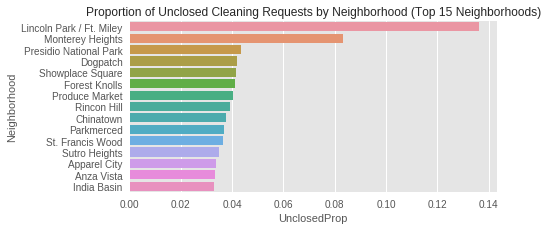

In [25]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "UnclosedProp", 
                    y = "Neighborhood",
                    data = counts.sort_values(by = "UnclosedProp",
                                              ascending = False).head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )
plt.title("Proportion of Unclosed Cleaning Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

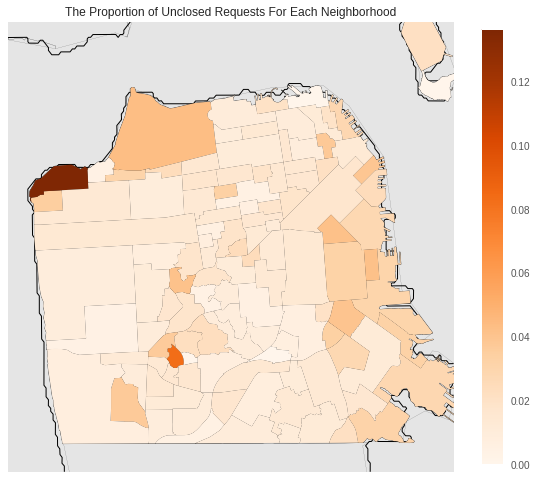

In [26]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, 
                llcrnrlat=37.7, 
                urcrnrlon=-122.36, 
                urcrnrlat=37.83, 
                resolution="f",
                projection="merc") 

myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['UnclosedProp'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['UnclosedProp'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Proportion of Unclosed Requests For Each Neighborhood")

Use supervisor district where there are too many neighborhoods. 

In [27]:
request_counts = street.groupby(by = "Request Type").count().reset_index().ix[:,["Request Type","CaseID"]].sort_values(by = "CaseID", ascending = False)
request_counts.head()

Request Type  CaseID
1           Bulky Items  187943
5      General Cleaning  176887
15    Sidewalk_Cleaning  174112
6   Hazardous Materials   81836
8       Illegal_Dumping   45221

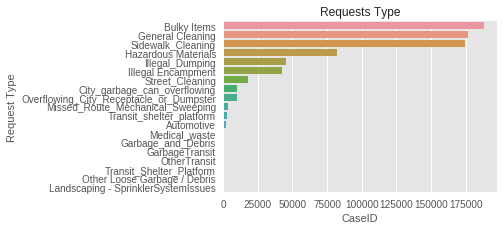

In [28]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Request Type", 
                    x = "CaseID",
                    data = request_counts, 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
plt.title("Requests Type") 
plt.show()

Differences by time of year:
- Mattresses in summer  
- Holiday shopping  


We added the month of each request to compare the counts of requests by month.  

In [29]:
street['month'] = [timestamp.month for timestamp in street.Opened]

In [30]:
count_by_month = street.groupby(by='month').count().CaseID.reset_index()
count_by_month

month  CaseID
0       1   75931
1       2   62432
2       3   50985
3       4   49355
4       5   53024
5       6   58159
6       7   64962
7       8   70538
8       9   69159
9      10   70330
10     11   66416
11     12   63433

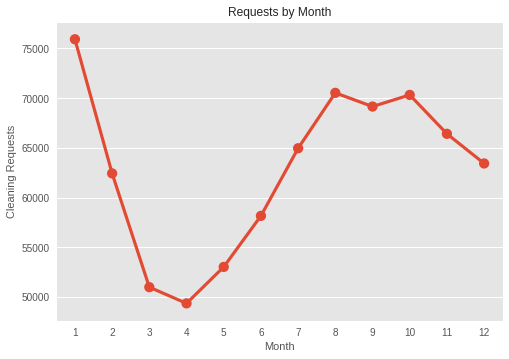

In [31]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

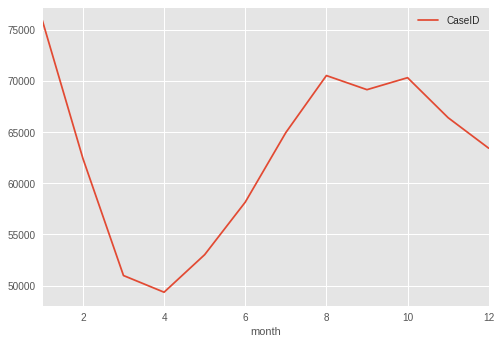

In [32]:
count_by_month.plot(y = "CaseID", 
                    x = "month")

Faster at closing requests by time?
Time to close requests by neighborhood?

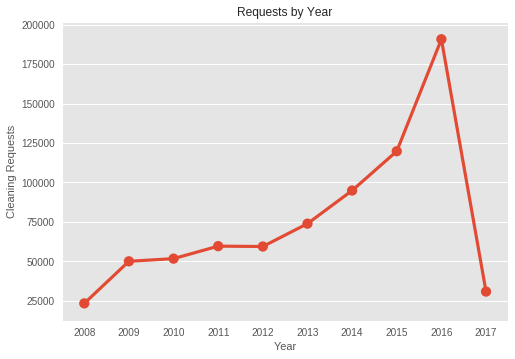

In [33]:
street['year'] = [timestamp.year for timestamp in street.Opened]
count_by_year = street.groupby(by='year').count().CaseID.reset_index()
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "year",
                    data = count_by_year, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Year")
plt.title("Requests by Year") 
plt.show()

In [34]:
[(colname, len(street[colname].unique())) for colname in list(street)]

[('CaseID', 747388),
 ('Opened', 737334),
 ('Closed', 538929),
 ('Status', 2),
 ('Responsible Agency', 130),
 ('Address', 101638),
 ('Category', 1),
 ('Request Type', 20),
 ('Request Details', 127),
 ('Source', 8),
 ('Supervisor District', 14),
 ('Neighborhood', 125),
 ('Updated', 547538),
 ('Point', 107789),
 ('AreaSqMi', 94),
 ('Females', 102),
 ('HousePrice', 77),
 ('Males', 102),
 ('MedAgeF', 89),
 ('MedAgeM', 77),
 ('MedHouseholdIncome', 102),
 ('MedRent', 99),
 ('PeoplePerSqMi', 103),
 ('Population', 103),
 ('month', 12),
 ('year', 10)]

In [35]:
by_month_req_type = street.groupby(by=['month','Request Type']).count().CaseID.reset_index()
by_month_req_type = by_month_req_type.sort_values(by = ['month', "CaseID"], ascending=[True,False])
by_month_req_type.head()

month         Request Type  CaseID
4       1     General Cleaning   21770
1       1          Bulky Items   19431
11      1    Sidewalk_Cleaning   14563
5       1  Hazardous Materials    7847
6       1   Illegal Encampment    4450

### Demographic Plots

join demographics with summary of street:  
- req
- prop unfilled
- time to fill req
- req / pop / area?

look for corr between those and:  
- HousePrice
- Income
- rent
- pop density


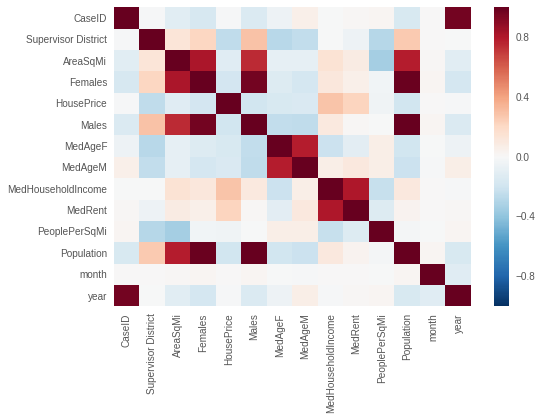

In [36]:
# Source: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
corr = street.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

--------

## Events and Festivals

### Pride

In [37]:
# Read the data scraped in the other notebook
pride = pd.DataFrame.from_csv("pride.csv")
pride

DateOpened  ReqCount_y  attendance_num_x  Year StartNoTime   EndNoTime
0  2009-06-27          39         1200000.0  2009  2009-06-27  2009-06-28
1  2010-06-26          61         1200000.0  2010  2010-06-26  2010-06-27
2  2011-06-25          63         1000000.0  2011  2011-06-25  2011-06-26
3  2012-06-23          56               NaN  2012  2012-06-23  2012-06-24
4  2013-06-29          37         1500000.0  2013  2013-06-29  2013-06-30
5  2014-06-28          62         1700000.0  2014  2014-06-28  2014-06-29
6  2015-06-27          68         1800000.0  2015  2015-06-27  2015-06-28
7  2016-06-25         108               NaN  2016  2016-06-25  2016-06-26

### Outside Lands Music and Arts Festival

In [38]:
url_ol = "https://en.wikipedia.org/wiki/Outside_Lands_Music_and_Arts_Festival"
response = requests.get(url_ol)
response.raise_for_status

ol_bs = BeautifulSoup(response.text, 'lxml')


# Years are in h3
h3 = ol_bs.find_all(name = "h3")

ol = []

for h in h3:
    span = h.find_all(name = "span", attrs={"class":"mw-headline"})
    
    # If there is a span in the h3
    if span:
        year = span[0].text
        #print year 
        
        check_p = True
        
        #dates = []
        
        for sibling in h.find_next_siblings(limit=5):
            
            # Days are in h4 or p
            if sibling.name == "h4":
                #print "h4" + "\t" + sibling.text
                ol.append([year, sibling.text.replace(u"\u2013", "-").replace("[edit]","")])
                # If an h4 was found, stop looking for p
                check_p = False
                
            elif sibling.name == "p" and check_p:
                #print check_p
                #print "p" + "\t" + sibling.text
                ol.append([year, sibling.text.replace(u"\u2013", "-")])
                # Formatting for 2011+ uses the date in a p tag
                if "August" in sibling.text:
                    break
                
        #print "\n"
        #ol[str(year)] = dates

ol

[[u'2008', u'Friday August 22'],
 [u'2008', u'Saturday August 23'],
 [u'2008', u'Sunday August 24'],
 [u'2009', u'Friday August 28'],
 [u'2009', u'Saturday August 29'],
 [u'2010', u'Saturday August 14'],
 [u'2010', u'Sunday August 15'],
 [u'2011', u'August 12-14'],
 [u'2012', u'August 10-12'],
 [u'2013', u'August 9-11'],
 [u'2014', u'August 8-10'],
 [u'2015', u'August 7-9'],
 [u'2016', u'August 5-9']]

In [39]:
# Separate the date ranges and fix the formatting

ol2 = []
for year_and_date in ol:
    
    date_split = year_and_date[1].split()
    month = date_split[0]
    if len(date_split) > 2:
        # keep the year
        year_and_date_new = [year_and_date[0]]
        year_and_date_new.extend(date_split[1:])
        ol2.append(year_and_date_new)
    else:
        days = date_split[1].split("-")
        for day in days:
            # keep the year
            year_and_date_new = [year_and_date[0]]
            year_and_date_new.append(month)
            year_and_date_new.append(day)
            ol2.append(year_and_date_new)

ol2

[[u'2008', u'August', u'22'],
 [u'2008', u'August', u'23'],
 [u'2008', u'August', u'24'],
 [u'2009', u'August', u'28'],
 [u'2009', u'August', u'29'],
 [u'2010', u'August', u'14'],
 [u'2010', u'August', u'15'],
 [u'2011', u'August', u'12'],
 [u'2011', u'August', u'14'],
 [u'2012', u'August', u'10'],
 [u'2012', u'August', u'12'],
 [u'2013', u'August', u'9'],
 [u'2013', u'August', u'11'],
 [u'2014', u'August', u'8'],
 [u'2014', u'August', u'10'],
 [u'2015', u'August', u'7'],
 [u'2015', u'August', u'9'],
 [u'2016', u'August', u'5'],
 [u'2016', u'August', u'9']]

In [40]:
ol_dates = pd.to_datetime([" ".join(date) for date in ol2])
ol_dates

DatetimeIndex(['2008-08-22', '2008-08-23', '2008-08-24', '2009-08-28',
               '2009-08-29', '2010-08-14', '2010-08-15', '2011-08-12',
               '2011-08-14', '2012-08-10', '2012-08-12', '2013-08-09',
               '2013-08-11', '2014-08-08', '2014-08-10', '2015-08-07',
               '2015-08-09', '2016-08-05', '2016-08-09'],
              dtype='datetime64[ns]', freq=None)

# Events Plots

We merged data about attendance scraped from the [San Francisco Pride Wikipedia Page](https://en.wikipedia.org/wiki/San_Francisco_Pride) with the requests data to find the number of requests that were submitted on the days of the parade and in the neighborhoods surrounding the parade, shown in the following table.    

In [41]:
pride

DateOpened  ReqCount_y  attendance_num_x  Year StartNoTime   EndNoTime
0  2009-06-27          39         1200000.0  2009  2009-06-27  2009-06-28
1  2010-06-26          61         1200000.0  2010  2010-06-26  2010-06-27
2  2011-06-25          63         1000000.0  2011  2011-06-25  2011-06-26
3  2012-06-23          56               NaN  2012  2012-06-23  2012-06-24
4  2013-06-29          37         1500000.0  2013  2013-06-29  2013-06-30
5  2014-06-28          62         1700000.0  2014  2014-06-28  2014-06-29
6  2015-06-27          68         1800000.0  2015  2015-06-27  2015-06-28
7  2016-06-25         108               NaN  2016  2016-06-25  2016-06-26

We used a scatterplot to see if there might be an association between the event attendance and the number of requests.

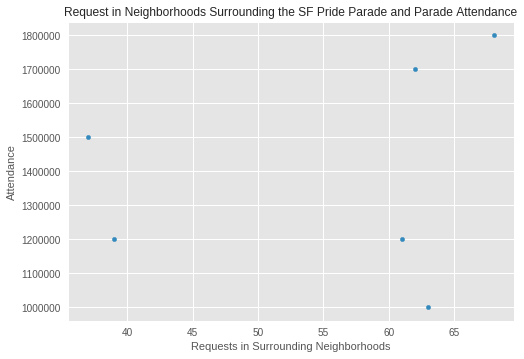

In [42]:
pride.plot(x="ReqCount_y", y="attendance_num_x", kind="scatter")
plt.title("Request in Neighborhoods Surrounding the SF Pride Parade and Parade Attendance")
plt.ylabel("Attendance")
plt.xlabel("Requests in Surrounding Neighborhoods")

There does not seem to be an association between the pride parade and requests in the surrounding neighborhoods.  
We used the correlation between these variables, shown below, for confirmation:  

In [43]:
pride[["ReqCount_y", "attendance_num_x"]].corr()

ReqCount_y  attendance_num_x
ReqCount_y           1.00000           0.20293
attendance_num_x     0.20293           1.00000

# Outside Lands

We used the dates of the Outside Lands Festival obtained by scraping the Wikipedia page to assess any association between cleaning requests and the festival.

In [44]:
# Read the dates of the festival obtained from scraping
ol_dates_df = pd.DataFrame.from_csv("ol_dates.csv", parse_dates=["Festival_Date"])
#ol_dates_df

ol_dates = pd.DatetimeIndex(ol_dates_df.Festival_Date)
ol_dates

DatetimeIndex(['2008-08-22', '2008-08-23', '2008-08-24', '2009-08-28',
               '2009-08-29', '2010-08-14', '2010-08-15', '2011-08-12',
               '2011-08-14', '2012-08-10', '2012-08-12', '2013-08-09',
               '2013-08-11', '2014-08-08', '2014-08-10', '2015-08-07',
               '2015-08-09', '2016-08-05', '2016-08-09'],
              dtype='datetime64[ns]', name=u'Festival_Date', freq=None)

In [45]:
# Find all requests in August in Golden Gate Park
AugustRequests = street.loc[street["Opened"].dt.month == 8]
AugustRequests["DateOpened"] = AugustRequests["Opened"].dt.date 
OLNeighs = ["Golden Gate Park"]
AugustRequests = AugustRequests.loc[AugustRequests.Neighborhood.isin(OLNeighs)]

/home/tgordon/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
type(AugustRequests["DateOpened"].values[0])
type(ol_dates[0])

# Convert the dates
ol_dt = [d.date() for d in ol_dates]

# Select all cleaning requests on the days of the festival
ol_req = AugustRequests[AugustRequests.DateOpened.isin(ol_dt)]

# Count the cleaning requests on each day of the festival
ol_req_counts = ol_req[["CaseID", "DateOpened"]].groupby("DateOpened").count()
ol_req_counts

CaseID
DateOpened        
2008-08-22       2
2008-08-23       1
2008-08-24       2
2009-08-29       2
2010-08-15       1
2011-08-12       1
2011-08-14       1
2013-08-09       4
2014-08-08       2
2014-08-10       1
2015-08-07       1
2016-08-05       1

To determine if the number of cleaning requests on the days that Outside Lands took place was unusual, we compared it with the usual number of requests on days in August.  

In [47]:
# Add a new day column to allow groupby
AugustRequests["Day"] = AugustRequests["Opened"].dt.day

# Count the number of requests per day across all years
Aug_req_by_day = AugustRequests[["CaseID", "Day"]].groupby('Day').count()

# There are 8 years in the data set, so divide the counts by 8 to get the average for each day
Aug_req_by_day.CaseID = Aug_req_by_day.CaseID / 8

Aug_req_by_day.head()

CaseID
Day        
1     2.250
2     2.000
3     1.250
4     0.375
5     1.375

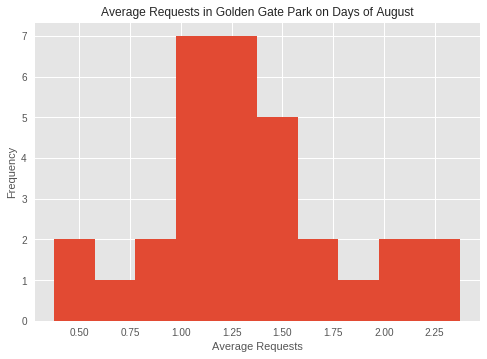

In [48]:
Aug_req_by_day.hist()
plt.title("Average Requests in Golden Gate Park on Days of August")
plt.xlabel("Average Requests")
plt.ylabel("Frequency")

In [49]:
np.mean(Aug_req_by_day.CaseID)

1.3064516129032258

In [50]:
np.median(Aug_req_by_day.CaseID)

1.25

From the mean and median, a "normal" number of requests in Golden Gate Park on a day in August is about 1.3. All but one of the number of requests on the days of the festival is 1 or 2, so it seems fairly clear that there is no consistent association between the festival and cleaning request in the park. 

Neither event we examined seems to be associated with increased cleaning requests. This may be because the city allocates additional cleaning resources in anticipation of large events, or the events may hire their own staff for cleaning.  

--------

## Maps

In [51]:
# Coordinates from https://en.wikipedia.org/wiki/San_Francisco and 
# http://andrew.hedges.name/experiments/convert_lat_long/
m = folium.Map(location=[37.783, -122.416], zoom_start=12)
m

In [52]:
# Points
street.ix[1,'Point']

'(37.7832142923006, -122.410764953722)'

In [53]:
def to_coordinates(point):
    """
    Converts a string in the format '(37.7695911772607, -122.415577110949)' to coordinates.
    """
    
    # Tests
    assert(isinstance(point, str) and point.startswith('(') and point.endswith(')'))
    
    (lat, lon) = point.split(',')
    
    # Remove '('
    lat = lat[1:]
    
    # Remove ')' and space
    lon = lon[:-1].strip()
    
    
    
    return (float(lat), float(lon))
    
to_coordinates(street.ix[1,'Point'])

(37.7832142923006, -122.410764953722)

In [54]:
# TODO: Make this a function
folium.Marker(to_coordinates(street.ix[1,'Point']), popup = street.ix[1,'Request Type']).add_to(m)
m

In [55]:
street_mattress = street[street["Request Details"] == "Mattress"]
street_mattress.head(2)

CaseID              Opened              Closed  Status Responsible Agency  \
2   322559 2008-11-30 22:20:00 2008-12-01 06:07:00  Closed      DPW Ops Queue   
10  322514 2008-11-30 19:08:00 2008-12-03 06:07:00  Closed      DPW Ops Queue   

                                         Address  \
2   1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109   
10      Intersection of 26TH ST and FAIR OAKS ST   

                        Category       Request Type Request Details    Source  \
2   Street and Sidewalk Cleaning    Illegal_Dumping        Mattress  Voice In   
10  Street and Sidewalk Cleaning  Sidewalk_Cleaning        Mattress  Voice In   

    ...   HousePrice    Males MedAgeF MedAgeM  MedHouseholdIncome  MedRent  \
2   ...    1276501.0   9415.0    41.4    39.1             88845.0   1401.0   
10  ...     799159.0  25373.0    36.9    36.2             96288.0   1461.0   

    PeoplePerSqMi  Population  month  year  
2         62679.0     19633.0     11  2008  
10        30764.0     45565.0     11  2008  

[2 rows x 26 columns]

In [56]:
len(street_mattress)

63013

In [57]:
mattress_count_by_month = street_mattress.groupby(by='month').count().CaseID.reset_index()

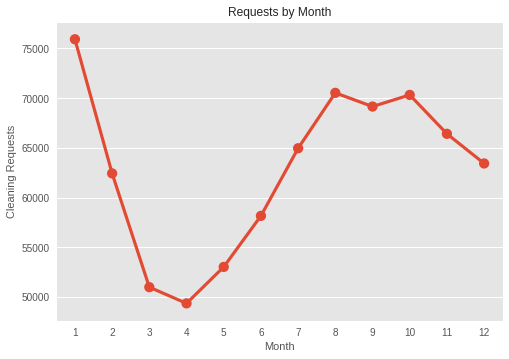

In [58]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

In [59]:
#from IPython.display import display
for index, row in street_mattress.iterrows():
    #print type(row["Status"])
    pass
    # Add to the map with marker cluster?
    # http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_clustered_markes.ipynb
    

In [60]:
mattress_map = folium.Map(location=[37.783, -122.416], zoom_start=12)
folium.GeoJson(open('Analysis Neighborhoods.geojson'), name='geojson').add_to(mattress_map)
mattress_map

In [61]:
# Neighborhood geojson from 
# https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

folium.GeoJson(open('Analysis Neighborhoods.geojson'), name='geojson').add_to(m)
m